# 화자 분리(Speaker Diarization)

* Speaker Diarization(화자 분리)는 오디오에서 각 부분에서의 화자를 인식하는 기술


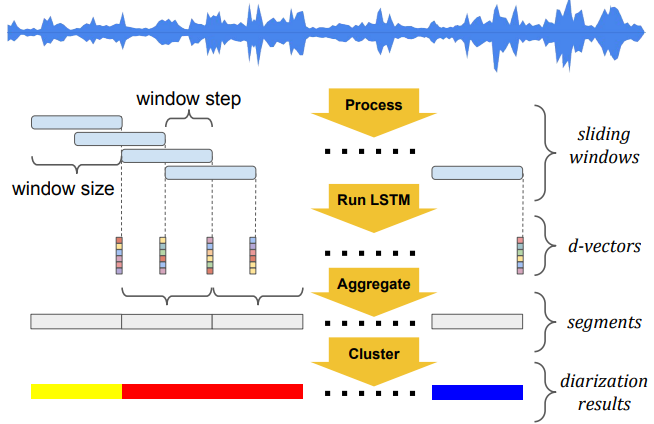

## UIS-RNN
- 대표적인 모델 Unbounded Interleaved-State Recurrent Neural Network (UIS-RNN)
    - https://github.com/google/uis-rnn
- 2019년 'Fully Supervised Speaker Diarization'란 이름으로 발표
- 'Fully'는 화자 수 추정을 포함하여 화자 분리 시스템의 모든 구성 요소가 감독되는 방식으로 교육되어 사용 가능한 레이블이 지정된 데이터의 양을 늘림으로써 이점을 얻을 수 있음을 의미
- 모든 화자의 임베딩이 매개 변수 공유 RNN (Recurrent Neural Network)에 의해 모델링되고 시간 도메인에서 인터리브 된 서로 다른 RNN 상태를 사용하여 서로 다른
화자를 구별


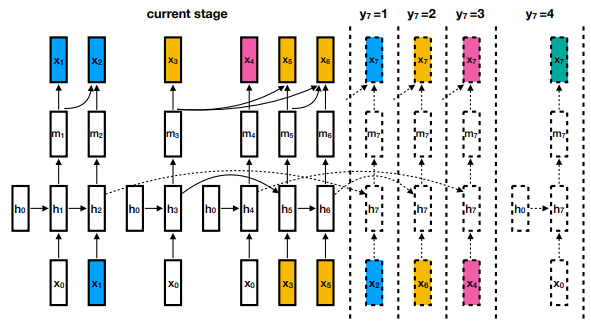

- 파란색, 노란색, 분홍색 및 녹색의 네 가지 가능한 화자가 있는 위의 예를 보면 (이는 임의적이며 실제로 더
많을 수 있다.) 
- 각 화자는 자체 RNN 인스턴스 (모든 화자간에 공유되는 공통 초기 상태)로 시작
- 이 화자의 새 임베딩이 주어지면 RNN 상태를 계속 업데이트
- 위 예에서 파란색 화자는 다른 화자인 노란색이 들어올 때까지 RNN 상태를 계속 업데이트
- 새 스피커 녹색이 입력되면 새 RNN 인스턴스로 시작

- waveform에 화자 정보를 label에 maping하기에는 상당히 어려움이 있다.
- UIS-RNN에서는 데이터 셋 제공
```
https://github.com/google/uis-rnn/blob/master/data/toy_training_data.npz?raw=True
https://github.com/google/uis-rnn/blob/master/data/toy_testing_data.npz?raw=True
```
- waveform을 Embedding은 d-vector을 이용했다고 git과 논문에 표시.   
※ d-vector 는 심층 신경망으로부터 추출된 특징

참고하여 진행
https://pypi.org/project/uisrnn/

## 라이브러리 설치


*   uisrnn을 간편하게 구현할 수 있는 uisrnn 라이브러리가 존재
*   여기서는 uisrnn 라이브러리를 통해 uisrnn을 구현하고 학습, 평가
*   실습을 위해 uisrnn과 easydict 라이브러리를 설치




In [ ]:
!pip install uisrnn easydict

## 데이터 다운로드

* 학습 및 평가에는 uisrnn 라이브러리에서 제공하는 sample dataset을 사용
* urlretrieve를 통해 url에서 데이터를 받아옴
* https://github.com/google/uis-rnn/blob/master/data/toy_training_data.npz?raw=True
* https://github.com/google/uis-rnn/blob/master/data/toy_testing_data.npz?raw=True



In [ ]:
import urllib.request

training_url = 'https://github.com/google/uis-rnn/blob/master/data/toy_training_data.npz?raw=True'
urllib.request.urlretrieve(training_url, './toy_training_data.npz')

testing_url = 'https://github.com/google/uis-rnn/blob/master/data/toy_testing_data.npz?raw=True'
urllib.request.urlretrieve(testing_url, './toy_testing_data.npz')

('./toy_testing_data.npz', <http.client.HTTPMessage at 0x7fecc926f150>)



*   다운로드한 데이터에서 데이터를 받아오고 sequence와 label을 분리



In [ ]:
import numpy as np
import uisrnn

train_data = np.load('./toy_training_data.npz', allow_pickle=True)
test_data = np.load('./toy_testing_data.npz', allow_pickle=True)

In [ ]:
train_data.files

['train_sequence', 'train_cluster_id']

In [ ]:
train_sequence = train_data['train_sequence']
train_cluster_id = train_data['train_cluster_id']

test_sequences = test_data['test_sequences']
test_cluster_ids = test_data['test_cluster_ids']

## 파라미터 설정

*   model, training, inference에 필요한 인자들은 uisrnn.parse_argement()를 통해 얻을 수 있음
*   colab 환경에서는 argument를 사용할 수 없기 때문에 easydict로 대체



In [ ]:
import easydict

model_args = easydict.EasyDict({'crp_alpha':1.0,
                                'enable_cuda': True,
                                'observation_dim':256,
                                'rnn_depth':1,
                                'rnn_dropout':0.2,
                                'rnn_hidden_size':512,
                                'sigma2':None,
                                'transition_bias':None,
                                'verbosity':2})

training_args = easydict.EasyDict({'batch_size':10,
                                   'enforce_cluster_id_uniqueness': True,
                                   'grad_max_norm':5.0,
                                   'learning_rate':0.001,
                                   'num_permutations':10,
                                   'optimizer':'adam',
                                   'regularization_weight':1e-05,
                                   'sigma_alpha':1.0,
                                   'sigma_beta':1.0,
                                   'train_iteration':10000})

inference_args = easydict.EasyDict({'batchsize':100,
                                    'look_ahead':1,
                                    'test_iteration':2,
                                    'beam_size':10})

easydict.EasyDict

## UISRNN 모델 학습



*   앞서 구성한 argment를 사용해 모델을 구성
*   데이터를 입력해 모델을 훈련



Iter: 0  	Training Loss: -284.2701    
    Negative Log Likelihood: 6.0478	Sigma2 Prior: -290.3185	Regularization: 0.0006
Iter: 10  	Training Loss: -298.2419    
    Negative Log Likelihood: 5.6274	Sigma2 Prior: -303.8699	Regularization: 0.0006
Iter: 20  	Training Loss: -311.6341    
    Negative Log Likelihood: 6.2917	Sigma2 Prior: -317.9265	Regularization: 0.0006
Iter: 30  	Training Loss: -326.8885    
    Negative Log Likelihood: 7.1488	Sigma2 Prior: -334.0380	Regularization: 0.0006
Iter: 40  	Training Loss: -345.6251    
    Negative Log Likelihood: 8.4286	Sigma2 Prior: -354.0544	Regularization: 0.0006
Iter: 50  	Training Loss: -368.2804    
    Negative Log Likelihood: 10.4105	Sigma2 Prior: -378.6916	Regularization: 0.0007
Iter: 60  	Training Loss: -402.7540    
    Negative Log Likelihood: 13.8563	Sigma2 Prior: -416.6110	Regularization: 0.0007
Iter: 70  	Training Loss: -447.2669    
    Negative Log Likelihood: 22.3654	Sigma2 Prior: -469.6330	Regularization: 0.0007
Iter: 80  	Tra

## 모델 평가



*   평가 데이터를 사용해 각 sequence에 해당하는 화자 id를 얻음



Ground truth labels: ['15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_0', '15_0', '15_0', '15_0', '15_0', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_2', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_0', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1', '15_1']
Predicted labels: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Config:
  sigma_alpha: 1.0
  sigma_beta: 1.0
  crp_alpha: 1.0
  learning rate: 0.001
  regularization: 1e-05
  batch size: 10

Performance:
  averaged accuracy: 0.987855
  accuracy numbers for all testing sequences:
    1.000000
    1.000000
    0.978723
    0.968085
    1.000000
    0.941860
    0.937500
    1.000000
    1.000000
    0.989362
    1.000000
    0.959184
    1.000000
    1.000000
    0.991870
    0.991597
    0.990654
    0.957447
    1.000000
    1.000000
    1.000000
    1.000000
    1.000000
    0.990099
    1.000000

